In [71]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz") # saves the downloaded file to this path
    if not tarball_path.is_file(): # checks if the file already exists, if not, it will download it
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path) # downloads the file from the URL and saves it to the specified path
    with tarfile.open(tarball_path) as housing_tarball: # opens the tarball file for reading
        housing_tarball.extractall(path="datasets") # extracts the contents of the tarball to the specified directory
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

C:\Users\YeXiaoJun\AppData\Local\Temp\ipykernel_5596\2253683659.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets") # extracts the contents of the tarball to the specified directory


## Take a Quick Look at the Data Structure

In [72]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [73]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [74]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [75]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


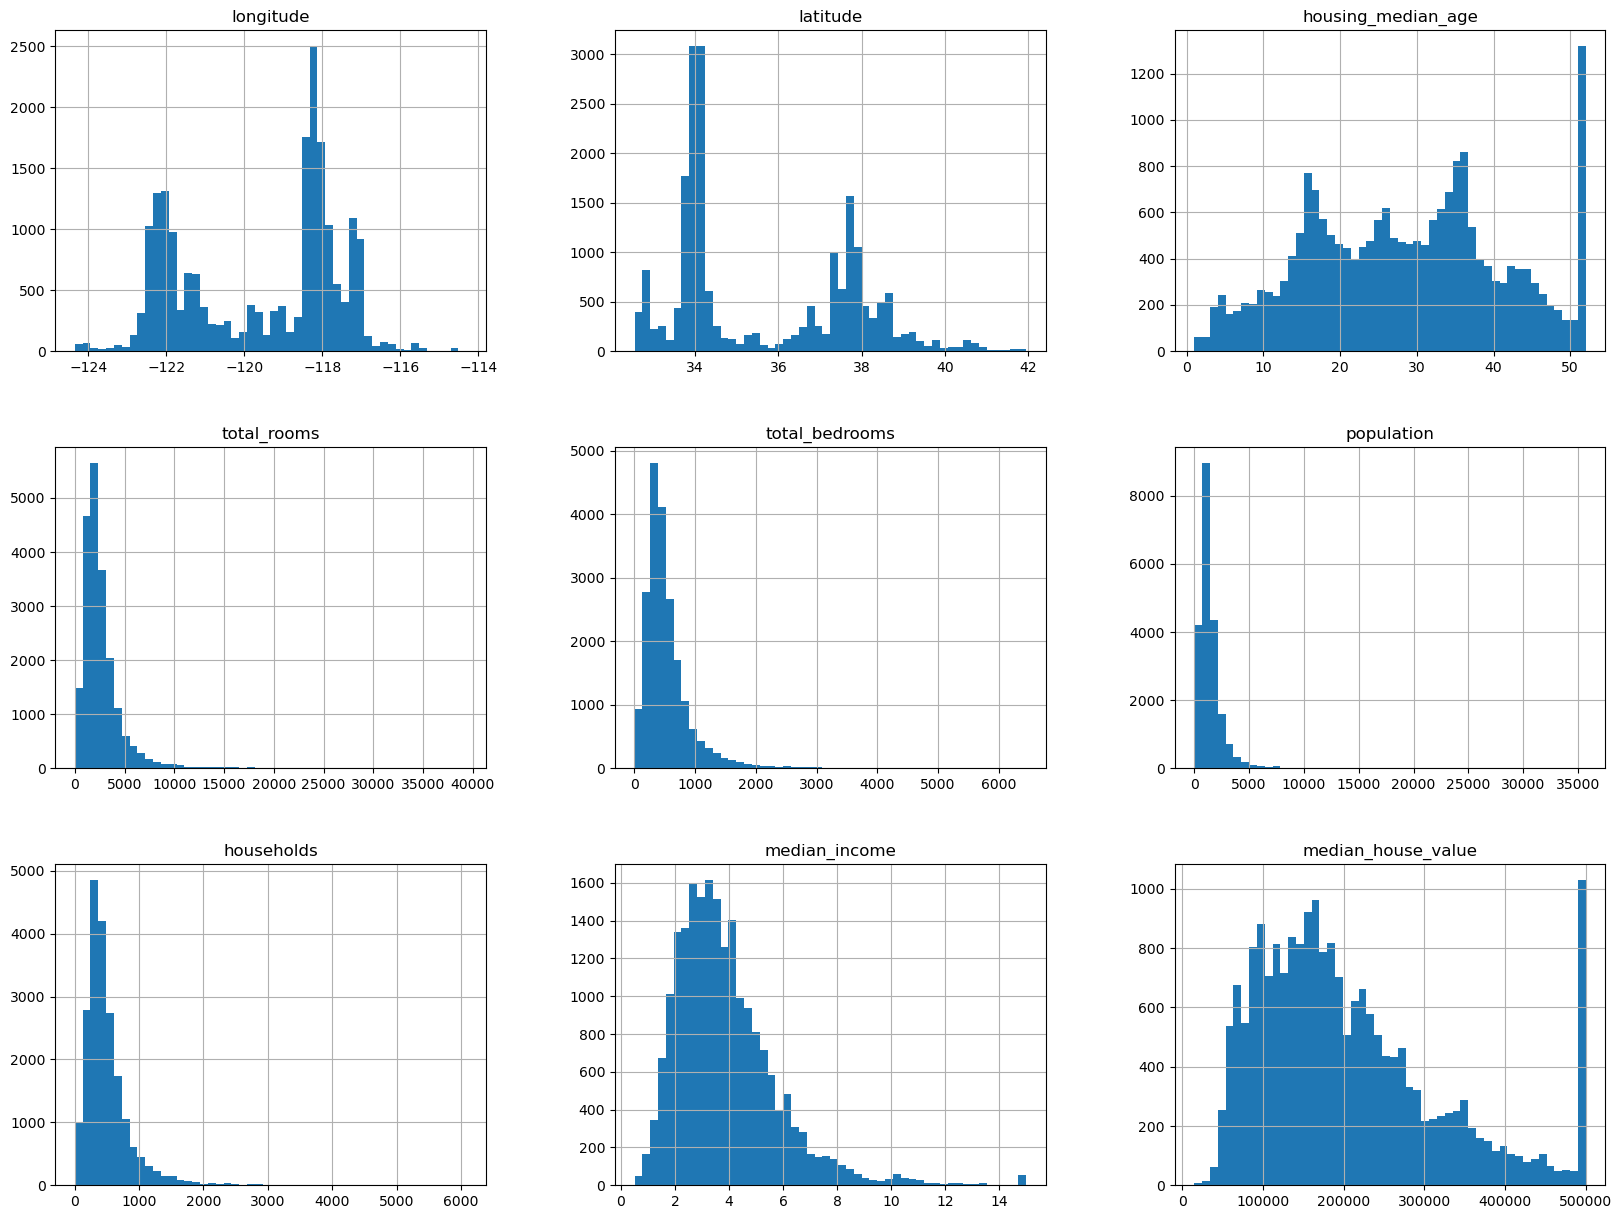

In [76]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15)) #creates histograms for each numerical attribute in the housing dataset, with 50 bins and a figure size of 20x15 inches
plt.show() # on the x-axis, it will display the range of values for each attribute, and on the y-axis, it will show the frequency of occurrences for each range of values.
# all three median are capped, median is the middle value of a sorted list
# data are right skewed, which means that the distribution of values is not symmetric and has a long tail on the right side. This can indicate that there are some extreme values or outliers in the dataset that may need to be addressed before applying machine learning algorithms.
# what we can do is to apply a log transformation or something similar to the data


## Create a test set

In [77]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # generates a random permutation of the indices of the data
    test_set_size = int(len(data) * test_ratio) # calculates the size of the test set based on the specified ratio
    test_indices = shuffled_indices[:test_set_size] # selects the indices for the test set from the shuffled indices starting from the beginning up to the calculated test set size exclusive (till test_set_size-1
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices] # returns the training set and test set based on the selected indices

In [78]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set), len(test_set)

(16512, 4128)

In [79]:
np.random.seed(42) # sets the random seed to ensure that the same random numbers are generated each time the code is run, which can be useful for reproducibility and debugging purposes
# but you should run this before calling np.random.permutation()
# but if we fetch an updated dataset, the test set will be different, which is not good for reproducibility. To solve this problem, we can use the hashlib library to create a hash of each instance's identifier and use that hash to determine whether an instance should be in the test set or the training set. This way, even if the dataset is updated, the same instances will be assigned to the test set and training set based on their identifiers.

In [80]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

In [81]:
# or I can just use Scikit-Learn's built-in function to split the dataset into a training set and a test set, which is more convenient and less error-prone than implementing the splitting logic manually.
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) # splits the housing dataset into a training set and a test set, with 20% of the data allocated to the test set. The random_state parameter is set to 42 to ensure that the same random split is generated each time the code is run, which can be useful for reproducibility and debugging purposes.

In [82]:
test_set["total_bedrooms"].isnull().sum()

np.int64(44)

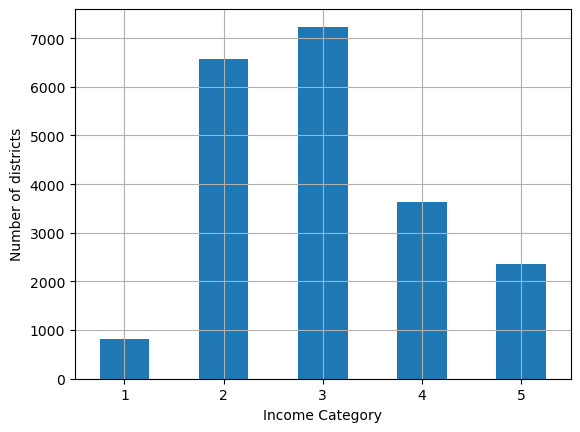

In [83]:
# Suppose some experts told us that the median income is an important attribute to predict the housing prices, and that it would be a good idea to ensure that both the training set and the test set are representative of the various categories of median income. To do this, we can create a new categorical attribute called `income_cat` by dividing the `median_income` attribute into several categories (e.g., using `pd.cut()`) and then use stratified sampling based on this new categorical attribute to split the dataset into a training set and a test set. This way, we can ensure that both sets have a similar distribution of median income categories, which can help improve the performance of our machine learning models.
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels = [1, 2, 3, 4, 5])

# housing["income_cat"].hist()
housing["income_cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)
# rot = 0 rotates the x-axis labels to be horizontal, and grid = True adds a grid to the plot for better readability.
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [84]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]): # make sure that the split is stratified based on the `income_cat` attribute, which ensures that both the training set and the test set have a similar distribution of median income categories.
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])


In [85]:
strat_train_set, strat_test_set = strat_splits[0]

# or simplier if we want to get only one split 
# stratify parameter is used to ensure that the split is stratified based on the specified attribute, which in this case is `income_cat`. This means that the distribution of the `income_cat` attribute will be similar in both the training set and the test set, which can help improve the performance of machine learning models that are sensitive to imbalanced data.
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [86]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [87]:
# now we drop the `income_cat` attribute so the data is back to its original state, and we can proceed with the rest of the analysis and modeling.
# the reason why we created the `income_cat` attribute was just to ensure that we had a representative split of the data based on median income categories, but now that we have our training set and test set, we can drop this temporary attribute since it is no longer needed for our analysis and modeling.
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

In [88]:
# now we procede with the training set forget the test set for now, we will need it later to evaluate our final model
housing = strat_train_set.copy()

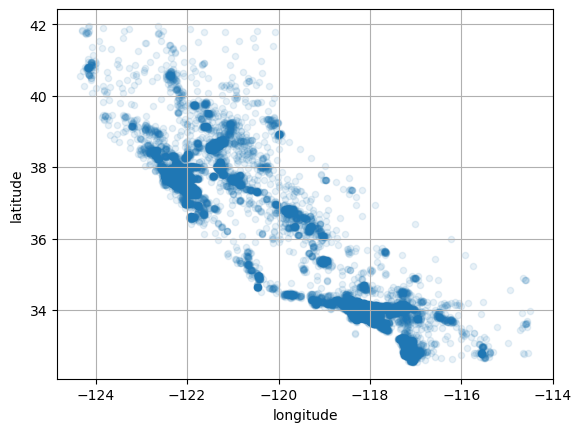

In [89]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid = True, alpha=0.1) # creates a scatter plot of the housing data, with longitude on the x-axis and latitude on the y-axis. The alpha parameter is set to 0.1 to make the points semi-transparent, which can help reveal patterns in the data when there are many overlapping points.
plt.show()
# so the points that are more densely packed together will appear darker and more visible, while areas with fewer points will appear lighter and less visible. This can help us identify areas with higher population density or more housing units, which may be important for our analysis and modeling.


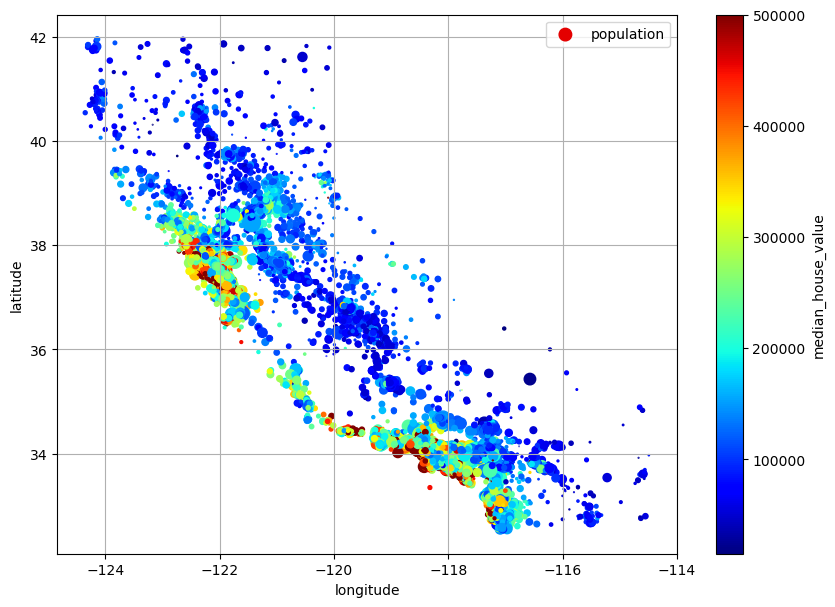

In [90]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population", # density based on population, the size of the points in the scatter plot is determined by the population attribute, with larger points representing areas with higher population density. The population values are divided by 100 to scale them down and make the points more visually distinguishable on the plot.
             c="median_house_value", cmap="jet", colorbar=True, # the color of the points in the scatter plot is determined by the median_house_value attribute, with a colormap of "jet" that maps lower values to cooler colors and higher values to warmer colors. The colorbar parameter is set to True to display a colorbar that shows the mapping of colors to median house values.
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

# We see that the median house value is correlated with location and population density, which means that the location and population density of a housing unit can have an impact on its median house value. This suggests that these attributes may be important features to consider when building a machine learning model to predict housing prices.


## Look for Correlations 

In [91]:
# only measures linear correlation, which means that it can only capture the strength and direction of a linear relationship between two variables. If there is a non-linear relationship between the variables, the correlation coefficient may not accurately reflect the strength of the relationship. Additionally, correlation does not imply causation, so even if two variables are strongly correlated, it does not necessarily mean that one variable causes the other to change.
corr_matrix = housing.corr(numeric_only = True)
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

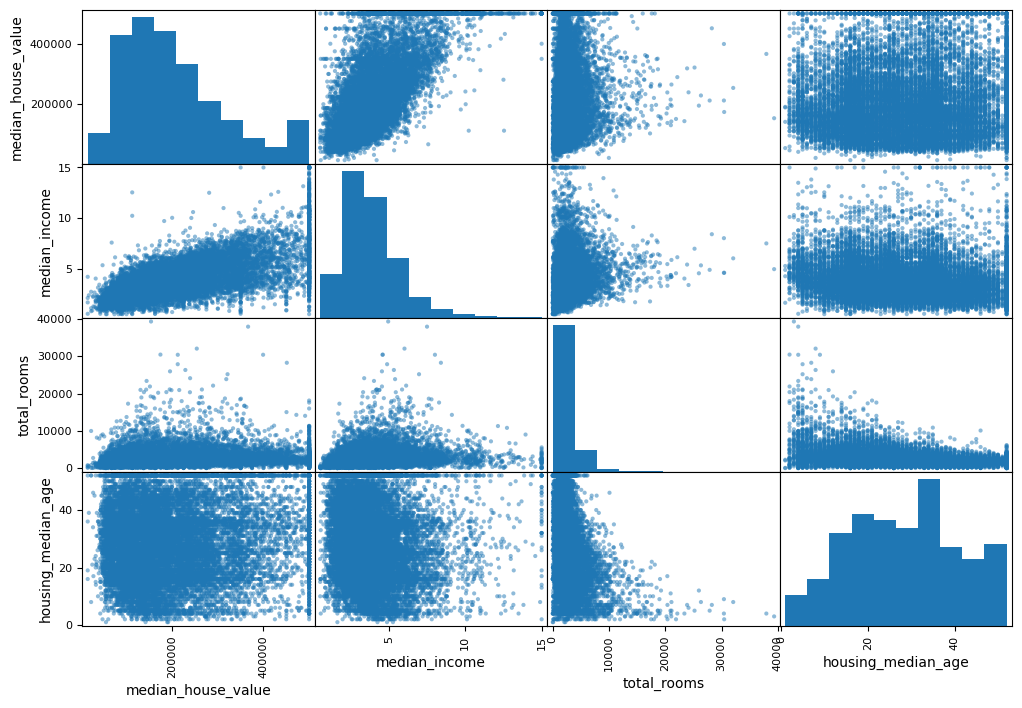

In [92]:
from pandas.plotting import scatter_matrix 

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12, 8))
plt.show()

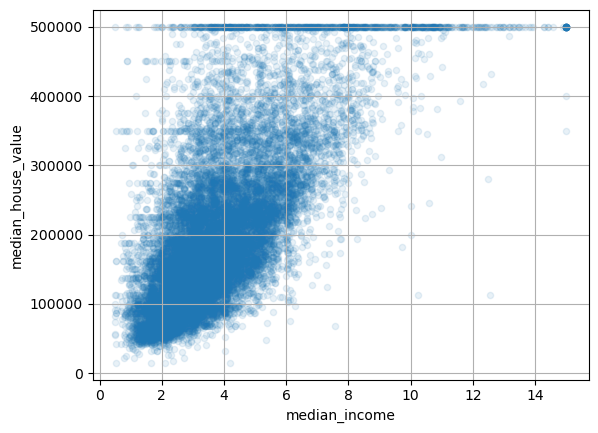

In [93]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid = True)
plt.show()

## Experiment with Attribute Combinations

In [94]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_house"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only = True)
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value      1.000000
median_income           0.688380
rooms_per_house         0.143663
total_rooms             0.137455
housing_median_age      0.102175
households              0.071426
total_bedrooms          0.054635
population             -0.020153
population_per_house   -0.038224
longitude              -0.050859
latitude               -0.139584
bedrooms_ratio         -0.256397
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms

In [95]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In [96]:
# 3 options to handle NaN values

# 1. drop the corresponding districts 
# housing.dropna(subset=["total_bedrooms"], inplace=True)
# 2. drop the whole attribute
#housing.drop("total_bedrooms", axis=1) 
# 3. set the values to some value (zero, the mean, the median, etc.), This is called imputation
# median = housing["total_bedrooms"].median() 
# housing["total_bedrooms"].fillna(median, inplace=True)

# We go for the 3rd option using SimpleImputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median") # creates an instance of the SimpleImputer class with the strategy set to "median", which means that it will replace missing values in the dataset with the median value of the corresponding attribute.
housing_num = housing.select_dtypes(include = [np.number]) # selects only the numerical attributes from the housing dataset and creates a new DataFrame called housing_num that contains only those attributes. This is done because the SimpleImputer can only be applied to numerical data, and we need to separate the numerical attributes from the categorical attributes before applying the imputation.
imputer.fit(housing_num) # computes the median values for each numerical attribute in the housing_num DataFrame and stores them in the imputer object. This step is necessary to prepare the imputer for transforming the dataset by replacing missing values with the computed medians.
imputer.statistics_ # the computed median values for each numerical attribute in the housing_num DataFrame

X = imputer.transform(housing_num) # applies the imputation transformation to the housing_num DataFrame, replacing any missing values with the corresponding median values computed during the fit step. The result is a new NumPy array X that contains the imputed values for the numerical attributes in the housing dataset.
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # creates a new DataFrame called housing_tr from the imputed NumPy array X, using the same column names and index as the original housing_num DataFrame. This allows us to maintain the structure of the original dataset while incorporating the imputed values for the numerical attributes.
# so in X we have only data without the labels, and in housing_tr we have the same data but in a DataFrame format with the same column names and index as the original housing_num DataFrame. This allows us to work with the imputed data in a more convenient way while still keeping track of the original structure of the dataset.

## Handling Text and Categorical Attributes

In [97]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10) 

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [98]:
from sklearn.preprocessing import OrdinalEncoder 
# the OrdinalEncoder is used to convert categorical attributes into numerical values by assigning a unique integer to each category. This is necessary because many machine learning algorithms can only work with numerical data, and categorical attributes need to be encoded before they can be used in the modeling process.
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) 
housing_cat_encoded[:10] 


array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [99]:
ordinal_encoder.categories_ # the unique categories for the ocean_proximity attribute, which are stored in the categories_ attribute of the ordinal_encoder object after fitting it to the housing_cat DataFrame. This information can be useful for understanding how the categorical data has been encoded and for interpreting the results of any machine learning models that use this encoded data.

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [100]:
from sklearn.preprocessing import OneHotEncoder
# the OneHotEncoder is used to convert categorical attributes into a binary matrix representation, where each category is represented as a separate binary feature. This is useful for machine learning algorithms that cannot work with categorical data directly and require numerical input. The OneHotEncoder creates new features for each category, allowing the model to learn from the presence or absence of each category in the dataset.
cat_encoder = OneHotEncoder() # OneHotEncoder(sparse_output=False) if we want to get the one-hot encoded representation in a dense array format instead of a sparse matrix.
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [101]:
# if we want to get the one-hot encoded representation of the ocean_proximity attribute in a dense array format, we can use the toarray() method of the sparse matrix returned by the fit_transform() method of the OneHotEncoder. This will convert the sparse matrix into a dense array format, where each row corresponds to a sample in the original housing_cat DataFrame, and each column corresponds to a unique category in the ocean_proximity attribute. The values in the array will be binary (0 or 1), indicating the presence or absence of each category for each sample.
# but if we have a large dataset, converting the sparse matrix to a dense array format may not be memory efficient, and it may be better to work with the sparse matrix directly or use other techniques to handle the categorical data.
# so it's preferred to work with the sparse matrix directly when dealing with large datasets, as it can save memory and computational resources. However, if we need to convert the sparse matrix to a dense array format for certain operations or visualizations, we can use the toarray() method, but we should be cautious about the size of the dataset and the potential memory usage.
housing_cat_1hot.toarray() # the one-hot encoded representation of the ocean_proximity attribute, which is a sparse matrix that has been converted to a dense array format. Each row in the array corresponds to a sample in the original housing_cat DataFrame, and each column corresponds to a unique category in the ocean_proximity attribute. The values in the array are binary (0 or 1), indicating the presence or absence of each category for each sample.

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16512, 5))

In [102]:
cat_encoder.categories_ # the unique categories for the ocean_proximity attribute, which are stored in the categories_ attribute of the cat_encoder object after fitting it to the housing_cat DataFrame. This information can be useful for understanding how the categorical data has been one-hot encoded and for interpreting the results of any machine learning models that use this encoded data.

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Feature scaling and Transformation

In [103]:
# always fit the scaler to the training set only, and then use it to transform the training set and the test set. This is important to avoid data leakage, which occurs when information from the test set is used to create the model, leading to overly optimistic performance estimates. By fitting the scaler only on the training set, we ensure that the model is trained on data that is representative of what it will encounter in the real world, and we can evaluate its performance on the test set without any bias.
from sklearn.preprocessing import MinMaxScaler
# use min_max when we want to scale the features to a specific range, such as between 0 and 1 or between -1 and 1. This can be useful when the features have different scales and we want to ensure that they are on a similar scale for machine learning algorithms that are sensitive to the scale of the input data. The MinMaxScaler transforms the features by scaling them to a specified range, which can help improve the performance of certain machine learning models.
min_max_scaler = MinMaxScaler(feature_range = (-1, 1)) # creates an instance of the MinMaxScaler class with the feature_range parameter set to (-1, 1), which means that the scaler will transform the features in the dataset to a range between -1 and 1. This is useful for normalizing the data and ensuring that all features are on a similar scale, which can improve the performance of machine learning algorithms that are sensitive to the scale of the input data.
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num) # applies the MinMaxScaler transformation to the housing_num DataFrame, scaling the numerical features to a range between -1 and 1. The fit_transform() method computes the minimum and maximum values for each feature in the housing_num DataFrame and then scales the features accordingly, resulting in a new NumPy array housing_num_min_max_scaled that contains the scaled values for the numerical attributes in the housing dataset.


In [104]:
from sklearn.preprocessing import StandardScaler
# use standard_scaler when we want to standardize the features in the dataset by removing the mean and scaling to unit variance. This can be useful when the features have different scales and we want to ensure that they are on a similar scale for machine learning algorithms that are sensitive to the scale of the input data. The StandardScaler transforms the features by centering them around the mean and scaling them to have a standard deviation of 1, which can help improve the performance of certain machine learning models.
std_scaler = StandardScaler() # creates an instance of the StandardScaler class, which is used to standardize the features in the dataset by removing the mean and scaling to unit variance. This is useful for ensuring that all features have a similar scale and can improve the performance of machine learning algorithms that are sensitive to the scale of the input data.
housing_num_std_scaled = std_scaler.fit_transform(housing_num) # applies the StandardScaler transformation to the housing_num DataFrame, standardizing the numerical features by removing the mean and scaling to unit variance. The fit_transform() method computes the mean and standard deviation for each feature in the housing_num DataFrame and then scales the features accordingly, resulting in a new NumPy array housing_num_std_scaled that contains the standardized values for the numerical attributes in the housing dataset.

When a feature’s distribution has a heavy tail when values far from the mean are not rare and in such case we should transform the data to shrink the heavy tail and make the distribution roughly symmetrical (for example replace the feature with its square root or in a logarithmic way) or we can bucketize the feature

In [105]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [106]:
# example of how to use the StandardScaler to standardize the target variable (median_house_value) before training a linear regression model, and then inverse transform the predictions back to the original scale after making predictions on new data.
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [107]:
# or simply 
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers

In [108]:
from sklearn.preprocessing import FunctionTransformer 

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [109]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
# it measures the similarity of each district to a district with a housing_median_age of 35, based on the radial basis function (RBF) kernel. The resulting age_simil_35 variable will contain values that indicate how similar each district is to the reference district with a housing_median_age of 35, with higher values indicating greater similarity and lower values indicating less similarity.
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]], shape=(16512, 1))

In [110]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
# the sf_simil variable will contain values that indicate how similar each district is to the reference location of San Francisco, based on the radial basis function (RBF) kernel. Higher values in sf_simil will indicate greater similarity to San Francisco, while lower values will indicate less similarity. This can be useful for analyzing the relationship between location and housing prices, as well as for building machine learning models that take location into account.
# in such case how close a district is to San Francisco, the higher the similarity value in sf_simil will be, which can help us understand how location affects housing prices and make more informed predictions based on the proximity to San Francisco.
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]], shape=(16512, 1))

In [111]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))
# 1/2 and 3/4

array([[0.5 ],
       [0.75]])

In [112]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

# BaseEstimator is a base class for all estimators in scikit-learn, which provides a common interface for all estimators and allows them to be used in a consistent way. TransformerMixin is a mixin class that provides a fit_transform method for transformers, which allows them to be used in a scikit-learn pipeline. By inheriting from both BaseEstimator and TransformerMixin, we can create a custom transformer that can be easily integrated into our machine learning workflow and can be used in conjunction with other scikit-learn components.
# we create a custom transformer called StandardScalerClone that inherits from BaseEstimator and TransformerMixin, which allows us to create a transformer that can be used in a scikit-learn pipeline. This custom transformer will implement the functionality of the StandardScaler, which standardizes the features by removing the mean and scaling to unit variance. By creating our own transformer, we can customize its behavior and integrate it seamlessly into our machine learning workflow.
# this scaler is just a clone of the StandardScaler, but we can modify it to add additional functionality or to handle specific cases that the StandardScaler may not cover. For example, we could add a parameter to allow for different scaling methods (e.g., min-max scaling) or to handle missing values in a specific way. By creating our own transformer, we have the flexibility to tailor it to our specific needs and use it in our machine learning pipelines as needed.
class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean = True):
        self.with_mean = with_mean
    
    def fit(self, X, y = None):
        X = check_array(X) # checks that X is an array with finite float valeus
        self.mean_ = X.mean(axis = 0) # computes the mean of each feature in X and stores it in the mean_ attribute of the transformer
        self.scale_ = X.std(axis = 0) # computes the standard deviation of each feature in X and stores it in the scale_ attribute of the transformer
        self.n_featuers_in_ = X.shape[1]  # stores the number of features in X in the n_features_in_ attribute of the transformer, number of columns in X
        return self

    def transform(self, X):
        check_is_fitted(self) # looks for learned attributes with trailing _
        X = check_array(X) # checks that X is an array with finite float values
        assert self.n_features_in_ == X.shape[1] # checks that the number of features in X matches the number of features that were seen during fitting, which is stored in the n_features_in_ attribute of the transformer. If the number of features does not match, an AssertionError will be raised.      
        if self.with_mean: # checks if the with_mean parameter is set to True, which indicates that the transformer should center the data by subtracting the mean from each feature in X. If with_mean is False, the data will not be centered and will only be scaled by dividing by the standard deviation.
            X = X - self.mean_ # if with_mean is True, it centers the data by subtracting the mean from each feature in X
        return X / self.scale_ # scales the data by dividing each feature in X by the corresponding standard deviation stored in the scale_ attribute of the transformer, which standardizes the features to have unit variance.

In [113]:
from sklearn.cluster import KMeans
# So we fit the data to a KMeans model to find cluster centers
# and then we compute the similarity using rbf_kernel between each instance and the cluster centers, which gives us a new representation of the data based on its similarity to the cluster centers. This can be useful for capturing non-linear relationships in the data and for creating new features that can be used in machine learning models.
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 10, gamma = 10, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y = None, sample_weight = None): # we find 10 cluster centers in the training set
        self.kmeans_ = KMeans(self.n_clusters, n_init = 10, 
                              random_state = self.random_state) # where we memorize the cluster centers in the kmeans_ attribute of the transformer, which is an instance of the KMeans class from scikit-learn. The n_init parameter is set to 10, which means that the KMeans algorithm will be run 10 times with different random initializations, and the best result will be selected based on the inertia criterion. The random_state parameter is set to the value passed to the constructor of the ClusterSimilarity class, which allows for reproducibility of the results.
        self.kmeans_.fit(X, sample_weight = sample_weight) 
        return self

    def transform(self, X): # computes the similarity of each instance in X to the cluster centers found during fitting using the radial basis function (RBF) kernel. The rbf_kernel function from scikit-learn is used to compute the RBF kernel between the instances in X and the cluster centers stored in the kmeans_ attribute of the transformer. The gamma parameter is set to the value passed to the constructor of the ClusterSimilarity class, which controls the width of the RBF kernel and determines how quickly the similarity decreases as the distance from the cluster centers increases. The resulting similarity values are returned as a new array, where each row corresponds to an instance in X and each column corresponds to a cluster center.
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)
    
    def get_feature_names_out(self, names = None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    

In [114]:
cluster_simil = ClusterSimilarity(n_clusters = 10, gamma = 1., random_state = 42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]])
similarities[:5].round(2) # output the first 5 rows of the similarities array, rounded to 2 decimal places. Each row corresponds to an instance in the housing dataset, and each column corresponds to a cluster center found by the ClusterSimilarity transformer. The values in the array represent the similarity of each instance to each cluster center, with higher values indicating greater similarity. By rounding the values to 2 decimal places, we can make it easier to interpret the similarities and identify patterns in the data.
# what we usually do is to convert the array into a DataFrame and concatenate it with the original dataset


array([[0.  , 0.97, 0.  , 0.  , 0.  , 0.08, 0.  , 0.  , 0.13, 0.57],
       [0.12, 0.  , 0.98, 0.03, 0.  , 0.  , 0.  , 0.54, 0.  , 0.  ],
       [0.  , 0.75, 0.  , 0.  , 0.  , 0.44, 0.  , 0.  , 0.27, 0.28],
       [0.  , 0.  , 0.24, 0.5 , 0.  , 0.  , 0.  , 0.74, 0.  , 0.  ],
       [0.03, 0.  , 0.91, 0.11, 0.  , 0.  , 0.  , 0.75, 0.  , 0.  ]])

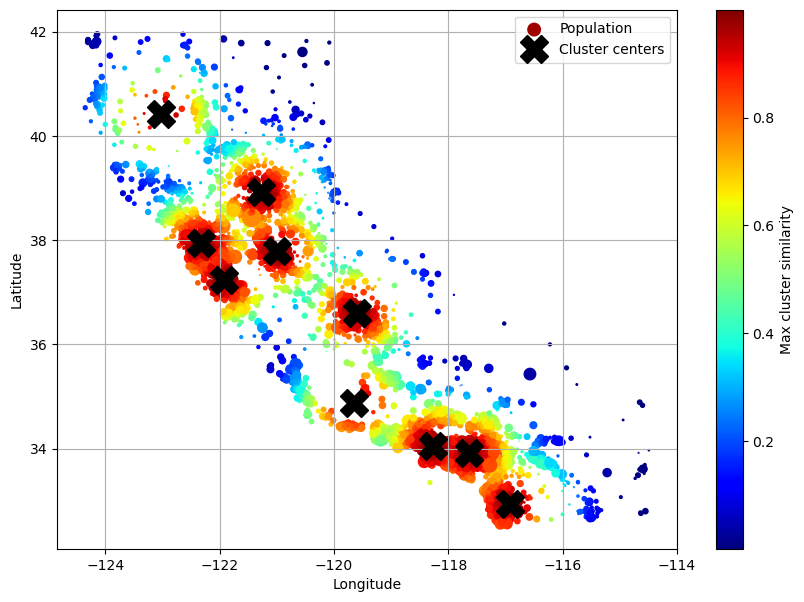

In [115]:
# extra code – this cell generates Figure 2–19

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_simil.kmeans_.cluster_centers_[:, 1],
         cluster_simil.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

## Transformation Pipelines

In [116]:
from sklearn.pipeline import Pipeline
# first we fill the NaN data with the imputer, and then we standardize the data using the scaler

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

In [117]:
from sklearn.pipeline import make_pipeline 

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [118]:
from sklearn import set_config

set_config(display='diagram')

num_pipeline

,steps,"[('simpleimputer', ...), ('standardscaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [119]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [120]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)
df_housing_num_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365


In [121]:
num_pipeline.steps




[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

In [122]:
num_pipeline[1] # the second step of the pipeline, which is the StandardScaler instance that we added to the pipeline. This allows us to access the StandardScaler and its attributes or methods directly from the pipeline object, which can be useful for inspecting the parameters of the scaler or for applying additional transformations to the data after scaling.

,copy,True
,with_mean,True
,with_std,True


In [123]:
num_pipeline[:-1] # all the steps of the pipeline except the last one, which in this case is just the SimpleImputer instance. This allows us to access all the steps of the pipeline except the last one, which can be useful for inspecting the parameters of the imputer or for applying additional transformations to the data before imputation. By slicing the pipeline object in this way, we can work with specific parts of the pipeline without having to access each step individually.

,steps,"[('simpleimputer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [124]:
num_pipeline.named_steps["simpleimputer"]

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [125]:
num_pipeline.set_params(simpleimputer__strategy="median")

,steps,"[('simpleimputer', ...), ('standardscaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [126]:
from sklearn.compose import ColumnTransformer

# num_attribs = housing_num.columns.tolist() maybe works?
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy = "most_frequent"),
    OneHotEncoder(handle_unknown = "ignore")    
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

# or more efficiently

from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [127]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared_fr = pd.DataFrame(
    housing_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=housing.index)
housing_prepared_fr.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


In [128]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape


(16512, 24)

In [129]:

preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

### Recap
- Use Imputer for missing values, median or something like for numerical values and most frequent for categorical
- One hot encode categorical values if the algorithm supports only numerical values
- Add features ratios if necessary, just like what we did to bedrooms, rooms_per_house and people_per_house to have a better correlation, make them more usefull
- Add cluster similarity features (more useful to the model with latitude and longitute)
- Log transformation to long tail features to have a Gaussian or uniform distribution
- Standardize numerical features

# Select and Train a Model

## Training and Evaluating on the Training Set

In [130]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression()) # we add the linear regression model to the pipeline, which allows us to fit the model to the preprocessed data in a single step. The make_pipeline function creates a pipeline that includes both the preprocessing steps and the linear regression model, allowing us to easily fit the model to the training data and make predictions on new data without having to manually apply each preprocessing step separately.
lin_reg.fit(housing, housing_labels) # fits the linear regression model to the training data, which consists of the original housing dataset (housing) and the corresponding labels (housing_labels). 

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [131]:
housing_predictions = lin_reg.predict(housing) # we get the predicted median house values
housing_predictions[:5].round(-2)

array([242800., 375900., 127500.,  99400., 324600.])

In [132]:
housing_labels.iloc[:5]

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
Name: median_house_value, dtype: float64

In [133]:
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False) # squared = False sets MSE to RMSE 

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68647.9568670666

Not a good result, the error is too big, it's underfitting

In [134]:
from sklearn.tree import DecisionTreeRegressor 

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('decisiontreeregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [135]:
housing_predictions = tree_reg.predict(housing) # predict will automatically do the transformation and then predict the labels, so we don't have to do the transformation separately
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

The error is 0, this seems to be too perfect, probable overfit

## Better Evaluation Using Cross-Validation

In [136]:
from sklearn.model_selection import cross_val_score 

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()
# it seems to perform poorly

count       10.000000
mean     66366.983603
std       1976.844743
min      63557.655007
25%      65004.623899
50%      65886.897085
75%      68129.026040
max      69530.301101
dtype: float64

In [137]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                               scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     46938.209246
std       1018.397196
min      45522.649195
25%      46291.334639
50%      47021.703303
75%      47321.521991
max      49140.832210
dtype: float64

In [138]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)
forest_rmse

17521.565358779884

What we did is simply to make a pipeline and then:
- use -cross_val_score that only returns the score to validate the model to see if there is overfitting or something like
- forest_rmse is still high on the training set -> high validation error and low training error means overfitting

# Fine-Tune Your Model

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]}, # 3*3 = 9
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]}, # 2*3 = 6
] # total 15 combinations of hyperparameters to try
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'preprocessing__geo__n_clusters': [5, 8, ...], 'random_forest__max_features': [4, 6, ...]}, {'preprocessing__geo__n_clusters': [10, 15], 'random_forest__max_features': [6, 8, ...]}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [140]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [141]:
grid_search.best_estimator_

,steps,"[('preprocessing', ...), ('random_forest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [142]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43007,43683,44158,43616
13,15,8,43697,44011,44819,44176
7,10,6,43710,44133,45227,44356
9,10,6,43710,44133,45227,44356
6,10,4,43798,44233,45100,44377


## Randomized Search

In [143]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [144]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV( # n_iter is the number of combinations to try
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42) # 30 fits total

rnd_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'preprocessing__geo__n_clusters': <scipy.stats....001F9E94AAA50>, 'random_forest__max_features': <scipy.stats....001F9E954A0D0>}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [146]:
rnd_search.best_params_

{'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}

In [145]:
# extra code – displays the random search results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41178,42385,42712,42092
8,32,7,41374,42579,43182,42378
0,41,16,42397,42640,43175,42738
5,42,4,41761,43348,43690,42933
2,23,8,42421,43138,43585,43048


## Analyze the Best Models and Their errors

In [147]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.  , 0.02, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [148]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(np.float64(0.1875325806969925), 'log__median_income'),
 (np.float64(0.07514024813315791), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06478794740923732), 'bedrooms__ratio'),
 (np.float64(0.05182951543531771), 'rooms_per_house__ratio'),
 (np.float64(0.048265139011229564), 'people_per_house__ratio'),
 (np.float64(0.04210984455078178), 'geo__Cluster 3 similarity'),
 (np.float64(0.023069532081900358), 'geo__Cluster 18 similarity'),
 (np.float64(0.02287273387758377), 'geo__Cluster 17 similarity'),
 (np.float64(0.021799932988950874), 'geo__Cluster 22 similarity'),
 (np.float64(0.01959066496209175), 'geo__Cluster 40 similarity'),
 (np.float64(0.018120158093537952), 'geo__Cluster 41 similarity'),
 (np.float64(0.017983159512483478), 'geo__Cluster 35 similarity'),
 (np.float64(0.01665570758839967), 'geo__Cluster 10 similarity'),
 (np.float64(0.016002696126672933), 'geo__Cluster 2 similarity'),
 (np.float64(0.015711984077222064), 'geo__Cluster 6 similarity'),
 (np.float64(0.01512618427202001

## Evaluate Your System on the Test Set

In [149]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41592.03010634003


In [150]:
from scipy import stats

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
boot_result = stats.bootstrap([squared_errors], rmse,
                              confidence_level=confidence, random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval

In [151]:
rmse_lower, rmse_upper

(np.float64(39664.07350648277), np.float64(43834.65613955853))

## Launch, Monitor and Maintain your System

In [ ]:
import joblib
# joblib is a library that provides tools for saving and loading Python objects, such as machine learning models, in a way that is efficient and easy to use. It allows you to serialize and deserialize Python objects, which can be useful for saving trained models to disk and loading them later for making predictions or further analysis. By using joblib, you can easily save your machine learning models and reuse them without having to retrain them every time you want to make predictions.
joblib.dump(final_model, "my_california_housing_model.pkl") 

['my_california_housing_model.pkl']

In [ ]:
import joblib

# extra code – excluded for conciseness
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

#class ClusterSimilarity(BaseEstimator, TransformerMixin):
#    [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = housing.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [ ]:
predictions

## Exercise 1

Essentialy:
- we create the Pipeline, 
- the param_grid with the name, for example 'svr__hyperparameterName' : [a serie of the actual hyperparameter value]
- rnd or grid search 
- fit
- look for best_score_ and best_params_

In [155]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

svr_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("svr", SVR())
])

param_grid = [
    {'svr__kernel': ['linear'], 
     'svr__C' : [10., 30., 100., 300., 1000., 3000., 10000., 30000.]},
    {'svr__kernel': ['rbf'], 
     'svr__C' : [1., 3., 10., 30., 100., 300., 1000.], 
     'svr__gamma': [0.01, 0.03, 0.1, 0.3, 1., 3.]},
] # two models to try: linear and rbf, with different hyperparameters for each

grid_search = GridSearchCV(svr_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000]) # we use only the first 5000 instances to speed up the search
 

,estimator,"Pipeline(step...svr', SVR())])"
,param_grid,"[{'svr__C': [10.0, 30.0, ...], 'svr__kernel': ['linear']}, {'svr__C': [1.0, 3.0, ...], 'svr__gamma': [0.01, 0.03, ...], 'svr__kernel': ['rbf']}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [156]:
svr_grid_search_rmse = -grid_search.best_score_
svr_grid_search_rmse

np.float64(69951.46871649081)

In [157]:
grid_search.best_params_

{'svr__C': 10000.0, 'svr__kernel': 'linear'}

## Exercise 2

In [161]:
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import expon, loguniform

param_distribs = {
    'svr__kernel' : ['linear', 'rbf'],
    'svr__C' : loguniform(20, 200_000),
    'svr__gamma' : expon(scale = 1.0),
}

rnd_search = RandomizedSearchCV(svr_pipeline, param_distributions=param_distribs,
                                n_iter=50, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)

rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000]) # we use only the first 5000 instances to speed up the search


,estimator,"Pipeline(step...svr', SVR())])"
,param_distributions,"{'svr__C': <scipy.stats....001F9E94AB770>, 'svr__gamma': <scipy.stats....001F9EA0111D0>, 'svr__kernel': ['linear', 'rbf']}"
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [162]:
svr_rnd_search_rmse = -rnd_search.best_score_
svr_rnd_search_rmse

np.float64(55805.373319544386)

In [163]:
rnd_search.best_params_

{'svr__C': np.float64(157055.10989448498),
 'svr__gamma': np.float64(0.26497040005002437),
 'svr__kernel': 'rbf'}

## Exercise 3

In [164]:
from sklearn.feature_selection import SelectFromModel
from scipy.stats import uniform
selector_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ('selector', SelectFromModel(RandomForestRegressor(random_state=42),
                                 threshold = 0.005)), # set or not threshold it will be overridden by the random search
    ('svr', SVR(C=rnd_search.best_params_["svr__C"],
                gamma=rnd_search.best_params_["svr__gamma"],
                kernel=rnd_search.best_params_["svr__kernel"])),
])

param_distribs = {
    'selector__threshold': uniform(0.001, 0.1),
}

rnd_search = RandomizedSearchCV(selector_pipeline, param_distributions=param_distribs,
                                n_iter=50, cv=3,
                                scoring='neg_root_mean_squared_error',
                                random_state=42)
rnd_search.fit(housing.iloc[:5000], housing_labels.iloc[:5000]) # we use only the first 5000 instances to speed up the search

,estimator,Pipeline(step...005002437)))])
,param_distributions,{'selector__threshold': <scipy.stats....001F9EA013110>}
,n_iter,50
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
selector_rmses = -cross_val_score(selector_pipeline,
                                  housing.iloc[:5000],
                                  housing_labels.iloc[:5000],
                                  scoring="neg_root_mean_squared_error",
                                  cv=3)
pd.Series(selector_rmses).describe()

In [165]:
selector_rnd_search_rmse = -rnd_search.best_score_ 
selector_rnd_search_rmse

np.float64(55684.87011404626)

In [166]:
rnd_search.best_params_

{'selector__threshold': np.float64(0.01076721140063839)}